In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

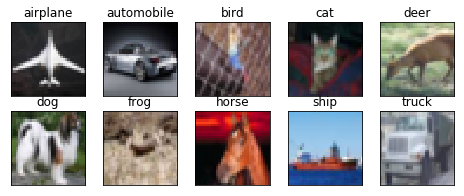

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.models import Input, Model
from keras.layers.convolutional import Conv2D,Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import SpatialDropout2D
from keras.layers import Activation, Flatten, Dense, Dropout, SeparableConv2D , DepthwiseConv2D, concatenate
from keras.layers import GlobalAveragePooling2D

In [24]:
# Define the model

model_input = Input (shape=(32,32,3))

# BLOCK - 1 ; NORMAL CONVOLUTION
X1 = Conv2D(32,(3,3), activation = 'relu', border_mode='same')(model_input)
X1 = BatchNormalization()(X1)
X1 = SpatialDropout2D(0.10)(X1)

X2 = Conv2D(64,(3,3), activation = 'relu', border_mode='same')(X1)
X2 = BatchNormalization()(X2)
X2 = SpatialDropout2D(0.10)(X2)


# BLOCK - 2 ; SEPARABLE CONOLUTIONS 
X3 = Conv2D(128,(3,1), activation = 'relu', border_mode='same')(X2)
X3 = BatchNormalization()(X3)
X3 = SpatialDropout2D(0.10)(X3)

X3 = Conv2D(128,(1,3), activation = 'relu', border_mode='same')(X3)
X3 = BatchNormalization()(X3)
X3 = SpatialDropout2D(0.10)(X3)


# BOTTLE NECK LAYER
X4 = MaxPooling2D(pool_size=(2, 2))(X3)
X4 = Conv2D(32,(1,1), activation = 'relu', border_mode='same')(X4)

# GROUPED CONVOLUTIONS
X5 = Conv2D(64,(3,3), activation = 'relu', border_mode='same')(X4)
X5 = BatchNormalization()(X5)
X5 = SpatialDropout2D(0.10)(X5)

X6 = Conv2D(64,(5,5), activation = 'relu', border_mode='same')(X4)
X6 = BatchNormalization()(X6)
X6 = SpatialDropout2D(0.10)(X6)

X7 = concatenate([X5,X6])
X7 = Conv2D(64,(1,1), activation = 'relu', border_mode='same')(X7)

# DEPTHWISE SEPERABLE
X8 = SeparableConv2D(128,(3,3), activation = 'relu', border_mode='same')(X7)
X8 = BatchNormalization()(X5)
X8 = SpatialDropout2D(0.10)(X5)

# BOTTLE NECK LAYER
X9 = MaxPooling2D(pool_size=(2, 2))(X8)
X9 = Conv2D(32,(1,1), activation = 'relu', border_mode='same')(X9)

# GROUP CONV WITH DILATION OF 1 & 2
X10 = Conv2D(64,(3,3), activation = 'relu', border_mode='same', dilation_rate = (1,1))(X9)
X10 = BatchNormalization()(X10)
X10 = SpatialDropout2D(0.10)(X10)

X11 = Conv2D(64,(3,3), activation = 'relu', border_mode='same', dilation_rate = (2,2))(X9)
X11 = BatchNormalization()(X11)
X11 = SpatialDropout2D(0.10)(X11)

X12 = concatenate([X10,X11])
X12 = Conv2D(64,(1,1), activation = 'relu', border_mode='same')(X12)

X12 = Conv2D(10,(3,3), activation = 'relu', border_mode='same')(X12)

X13 = GlobalAveragePooling2D()(X12)
X14 = Activation('softmax')(X13)


# MODEL BUILDING
model = Model(model_input, X14, name='Masala_CNN_:-)')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", padding="same")`
/usr/local/lib/python3.6

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 32, 32, 32)   128         conv2d_45[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_34 (SpatialDr (None, 32, 32, 32)   0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_46 

Epoch 1/50
  1/390 [..............................] - ETA: 37s - loss: 1.4001 - acc: 0.4453

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


390/390 [==============================] - 29s 75ms/step - loss: 1.1917 - acc: 0.5702 - val_loss: 1.2965 - val_acc: 0.5458
Epoch 2/50
390/390 [==============================] - 29s 74ms/step - loss: 0.9586 - acc: 0.6592 - val_loss: 0.8472 - val_acc: 0.7008
Epoch 3/50
390/390 [==============================] - 29s 74ms/step - loss: 0.8472 - acc: 0.6997 - val_loss: 0.7984 - val_acc: 0.7128
Epoch 4/50
390/390 [==============================] - 29s 73ms/step - loss: 0.7687 - acc: 0.7311 - val_loss: 0.7193 - val_acc: 0.7457
Epoch 5/50
390/390 [==============================] - 29s 74ms/step - loss: 0.7062 - acc: 0.7528 - val_loss: 0.7101 - val_acc: 0.7519
Epoch 6/50
390/390 [==============================] - 28s 73ms/step - loss: 0.6589 - acc: 0.7698 - val_loss: 0.6390 - val_acc: 0.7744
Epoch 7/50
390/390 [==============================] - 28s 73ms/step - loss: 0.6244 - acc: 0.7830 - val_loss: 0.7129 - val_acc: 0.7552
Epoch 8/50
390/390 [==============================] - 28s 73ms/step - los

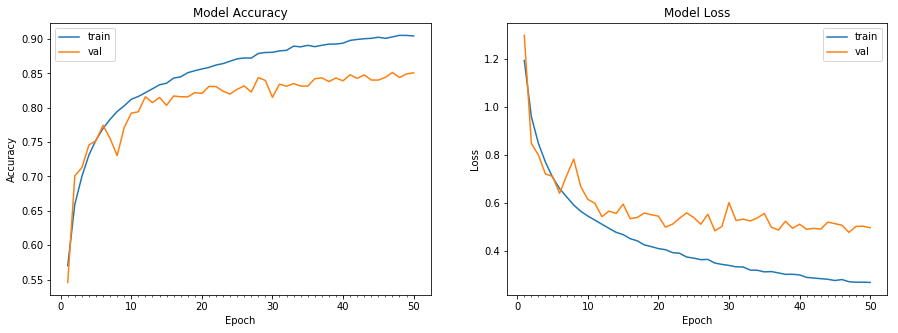

Accuracy on test data is: 85.07


In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
# Save the weights
model.save_weights('/content/drive/My Drive/Cifar/My_6B_1_Checkpoint')

In [0]:
# Restore the weights
model.load_weights('/content/drive/My Drive/Cifar/My_6B_1_Checkpoint')

In [28]:
loss,acc = model.evaluate(test_features, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

10000/10000 [==============================] - 2s 199us/step
Restored model, accuracy: 85.07%
